In [83]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/paragram-300-sl999/paragram_300_sl999.txt
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/wikinews300d1mvec/wiki-news-300d-1M.vec


In [84]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tqdm import tqdm
import math

import seaborn as sns
%matplotlib inline

import gc
gc.collect()
time.sleep(5)

In [85]:
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
print(train_df.shape)
print(test_df.shape)
display(train_df.head())

(1306122, 3)
(375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Check for data imbalance

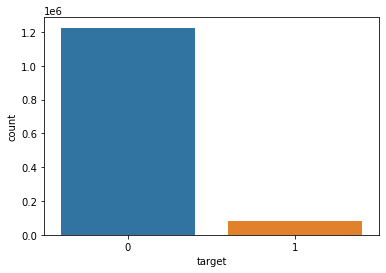

In [86]:
sns.countplot(train_df.target)

Check for missing values

In [87]:
train_df.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [88]:
test_df.isna().sum()

qid              0
question_text    0
dtype: int64

Do the following in the next steps:

* Split the train into train and validation sets. We will not do cross valdiation as it is time consuming
* No missing values identified, if any, replace them with 'na'
* Tokenize the `text` column and convert them to vector sequences
* Pad or truncate the sequences as required - truncation happens when sequence length exceeds `max_len` and if less, they will be padded

In [89]:
%%time
# split into train and validation sets

train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=2020)

# some config values for tokenization and vector sequences

max_len = 100        # max number of words in the question that will be used
max_features = 50000 # max number of features or unique words we will use from the entire corpus (the same as number of rows in the embedding matrix)
embed_size = 300     # size of each embedding or word vector

CPU times: user 328 ms, sys: 2.23 ms, total: 330 ms
Wall time: 420 ms


In [90]:
%%time
# substitute missing values in text
train_X = train_df['question_text'].fillna("_na_")
valid_X = valid_df['question_text'].fillna("_na_")
test_X = test_df['question_text'].fillna("_na_")

# tokenize the sentences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = max_features)

# fit on train_X. fit_on_texts() expects a list of text as input
tokenizer.fit_on_texts(train_X.values.tolist())

# use fit_to_sequences method to encode the tokens or words into interger sequences
train_X = tokenizer.texts_to_sequences(train_X.values)
valid_X = tokenizer.texts_to_sequences(valid_X.values)
test_X = tokenizer.texts_to_sequences(test_X.values)

# pad the sentences, according to the max_len
from keras.preprocessing.sequence import pad_sequences

train_X = pad_sequences(train_X, maxlen = max_len)
valid_X = pad_sequences(valid_X, maxlen = max_len)
test_X = pad_sequences(test_X, maxlen = max_len)

# store the target values
train_y = train_df['target'].values
valid_y = valid_df['target'].values

CPU times: user 1min 16s, sys: 140 ms, total: 1min 17s
Wall time: 1min 17s


### Without using any of the trained embeddings provided:
We will learn the embeddings from scratch without using any of the trained embeddings as the first step. For this we will train a Bidirectional GRU model. We will use the CUDA based NN model from Nvidia known as th CuDNNGRU, which is GPU based.

In [91]:
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, CuDNNGRU, Dense, Dropout, LSTM, Conv1D, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
# tensorflow version check
import tensorflow as tf
print('tensor flow version in use: ', tf.__version__)

Using the CuDNNGRU is not importable as it seems to have been deprecated in recent versions of TF and I keep getting error 'ModuleNotFoundError: No module named 'tensorflow.contrib'', this is because this model is removed in the current version.

The better way is to simply use the GRU and or LSTM as it is, which will default to `CuDNNGRU` and `CuDNNLSTM`, if certain conditions are met. Refer [here](https://stackoverflow.com/questions/60468385/is-there-cudnnlstm-or-cudnngru-alternative-in-tensorflow-2-0)

Refer to other links on how to import a `GRU` model:
1. https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNGRU
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = embed_size, input_length = max_len)) # input_shape is optional
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Train the model on the given train split and monitor the metric on the validation set. Run for 1 epochs for now. Changing the epochs, batch_size, model parameters could give a better model

In [ ]:
%%time
# train the model
model.fit(train_X, train_y, batch_size=512, epochs =1 , validation_data = (valid_X, valid_y))

In [ ]:
import pickle
pickle.dump(model, open('bidirectional_gru_keras_no_pretrain_embed.pkl', 'wb'))

*let's looks at the validation sample predictions and decide the best threshold for `F1` score. The actual values are `0` and `1`. Based on threshold, the predictions will vary.*

Here we are learning embeddings and we don't use any of the pretrained embeddings that have been provided along with the data

In [ ]:
prediction_noembed_val_y = model.predict([valid_X], batch_size=1024, verbose=1)

for thresh in np.arange(0.1, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    score = round(metrics.f1_score(valid_y, (prediction_noembed_val_y > thresh).astype(int)),4)
    print('F1 score at threshold {} is {}'.format(thresh, score))

In [ ]:
# predictions on test(no pretrained embedding in use)
pred_noembed_y = model.predict([test_X], batch_size=1024, verbose=1)

In [ ]:
del model
gc.collect()

# pause execution for 10s after gc to allow gc to complete
time.sleep(10)

## Imported Glove840b300d embedding file from kaggle

Examine the contents of the embedding file. Each `line` represents a `token` and the correspoding `300D vector embedding`

In [ ]:
EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'

with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    for i in range(3):
        print(fp.readline())

For details on how what the `*` operator means, refer [here](https://stackoverflow.com/questions/11315010/what-do-and-before-a-variable-name-mean-in-a-function-signature)

Inside a function header:

* `*` unpacks a list or tuple into position arguments.

* `**` unpacks a dictionary into keyword arguments.

**I got infinity when computing the `standard deviation` after stacking the embedding values when using dtype as 'float16', but if using 'float32', this does not happen, in the below function**

In [ ]:
# extract the embeddings and the token from the text file
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

In [ ]:
# explore how we can use the * operator to unpack the list into a tuple
# do the same for the rest of tokens in each line of the file

with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    firstline = fp.readline()
    secondline = fp.readline()
    print(secondline)
    print(get_coefs(*secondline.split(" ")))

In [ ]:
%%time
EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'

with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    for o in fp:
        print(get_coefs(*o.split()))
        break

### Glove embeddings

In [ ]:
%%time
EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'
with open(EMBEDDING_FILE, 'r') as fp:
    embedding_index = dict(get_coefs(*o.split(" ")) for o in fp)

 Since all_embeds.std() is coming to 'inf' or Infinity, I hard code the values. 
 
 For mean, there is no issue  emb_mean,emb_std = -0.005838499,0.48782197

In [ ]:
%%time
print('Size of the embedding index: ', len(embedding_index))

# stack the embedding values to calculate the mean and std for a normal distribution
all_embeds = np.stack(list(embedding_index.values()))
embed_mean, embed_std = np.mean(all_embeds), np.std(all_embeds) # or all_embeds.mean(), all_embeds.std() will do
embed_size = all_embeds.shape[1]
print(embed_mean, embed_std)
print('embedding matrix shape', all_embeds.shape)
if embed_std == 'inf':
    embed_std = 0.48782197
print('new value for embed_std is: ', embed_std)

Lets look at the tokens from our training data and use the learned glove embeddings to extract the embeddings for those tokens only.
Before extracting, the embeddings are normalized. This is because, in the glove embeddings, there are some tokens in lower and upper case, which has different embeddings, though there are quite similar, while others don't have this. So it is better to normalize them before using the learned embeddings for the training data

In [ ]:
%%time
# get the tokens from our training data. Remember the Keras tokenizer has already beeen fit on the train text.

word_index = tokenizer.word_index
# vocab length should be 1 more to account for tokens which has embeddings missing
print('Number of unique words in the vocabulary is :', len(word_index) +1)

vocab_length = len(word_index)+1

# select minimum of tokens tokenized words from train and max_features we want to learn
nb_words = min(len(word_index), max_features)

''' Use the below when not going to normalize the distribution'''
embedding_matrix = np.zeros((len(word_index)+1, embed_size))

# normalize the distribution fo embeddings and store them in a matrix, the tokens will be added as keys in the next step
embedding_matrix = np.random.normal(embed_mean, embed_std, (nb_words+1, embed_size))

count_found = nb_words
missing_tokens =[]


for word, index in word_index.items():
    if index >= max_features:
        continue
    embedding_vector = embedding_index.get(word) # get the embedding vector for the word
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        count_found -=1
        missing_tokens.append(word)

print('Found embedding for {} words from the embeddings, from a total of {}'.format(count_found, nb_words))
       
print('Number of missing tokens are: ', len(missing_tokens))        
print('Size of the embedding matrix is: ', embedding_matrix.shape)

Now lets define a Neural network model to use the above as inputs.

The embedding layer can be seeded with the GloVe word embedding weights. Finally, we do not want to update the `learned word weights` in this model, therefore we will set the `trainable` attribute for the model to be `False`

The number of rows in the `embedding_matrix` should be the same as the `input_dim` for the `Embedding layer`

In [ ]:
del all_embeds, embedding_index, embedding_vector, missing_tokens
gc.collect()

In [ ]:
model = Sequential()
#model.add(Embedding(input_dim = max_features, output_dim = embed_size, input_length = max_len, weights=[embedding_matrix], trainable=False))
model.add(Embedding(input_dim = max_features+1, output_dim = embed_size, input_length = max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
%%time
model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=[valid_X, valid_y])

**Prediction using Glove embedding trained NN model**

In [ ]:
pred_glove_val_y = model.predict([valid_X], batch_size=1024, verbose=1)

# check the F1_score at different thresholds
for thresh in np.arange(0.1, 0.5, 0.01):
    score = metrics.f1_score(valid_y, (pred_glove_val_y > thresh).astype(int))
    print('F1_score at threshold {} is {}'.format(thresh, round(score, 3)))

In [ ]:
pred_glove_test_y = model.predict([test_X], batch_size=1024, verbose=1)

In [ ]:
del embedding_matrix
gc.collect()

## **Try with FastText Embeddings - wikinews300d1m**

In [ ]:
os.listdir('../input/wikinews300d1mvec')

In [ ]:
# Examine file content

EMBEDDING_FILE = '../input/wikinews300d1mvec/wiki-news-300d-1M.vec'

with open(EMBEDDING_FILE) as fp:
    next(fp)  # skip header
    print(fp.readline())

There was a problem when reading from the embedding file and converting it into a dictionary. The dict() method was not able to understand the inputs as token as vectors and hence used the `setdefault()` method of the dictionary, where we explicity mention what is the key and value pairs. More details on how to use it can be referred [here](https://www.geeksforgeeks.org/python-convert-list-tuples-dictionary/)

In [ ]:
dict_1 = dict()

i=1
with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    next(fp)
    for o in fp:
        temp = o.rstrip().split(" ", 1)
        print(temp)
        dict_1.setdefault(temp[0], temp[1])
        i-=1
        if i==0:
            break
print(dict_1)

In [ ]:
dict_1 = dict()

i=3
with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    next(fp)
    for o in fp:
        temp = get_coefs(*o.rstrip().split(" "))
        #print(temp)
        dict_1.setdefault(temp[0], temp[1])
            
#         print(temp[0])
#         print(temp[1])

#         print(dict(temp))
        i-=1
        if i==0:
            break
print(dict_1)

In [ ]:
%%time

EMBEDDING_FILE = '../input/wikinews300d1mvec/wiki-news-300d-1M.vec'

embedding_index = dict()

with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    next(fp)                                          # skip header
    for o in fp:
        temp = get_coefs(*o.rstrip().split(" "))
        #print(temp)
        embedding_index.setdefault(temp[0], temp[1])
        
# stack all the values
all_embed = np.stack(list(embedding_index.values()))
embed_mean, embed_std = all_embed.mean(), all_embed.std()
embed_size = all_embed.shape[1]

print('Embed mean : {} and std: {}'.format(embed_mean, embed_std))
print('Emebdding index size', all_embed.shape)

if embed_std == 'inf': # I got infinity when using dtype as 'float16', but if using 'float32', this does not happen
    embed_std = 0.48782197
print('new value for embed_std is: ', embed_std)

# get the tokens from our training data. Remember the Keras tokenizer has already beeen fit on the train text.

word_index = tokenizer.word_index
# vocab length should be 1 more to account for tokens which has embeddings missing
print('Number of unique words in the vocabulary is :', len(word_index) +1)

vocab_length = len(word_index)+1

# select minimum of tokens tokenized words from train and max_features we want to learn
nb_words = min(len(word_index), max_features)

''' Use the below when not going to normalize the distribution'''
embedding_matrix = np.zeros((len(word_index)+1, embed_size))

# normalize the distribution fo embeddings and store them in a matrix, the tokens will be added as keys in the next step
embedding_matrix = np.random.normal(embed_mean, embed_std, (nb_words+1, embed_size))

count_found = nb_words
missing_tokens =[]


for word, index in word_index.items():
    if index >= max_features:
        continue
    embedding_vector = embedding_index.get(word) # get the embedding vector for the word
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        count_found -=1
        missing_tokens.append(word)

print('Found embedding for {} words from the embeddings, from a total of {}'.format(count_found, nb_words))
       
print('Number of missing tokens are: ', len(missing_tokens))        
print('Size of the embedding matrix is: ', embedding_matrix.shape)

In [ ]:
del word_index, embedding_index, missing_tokens, all_embed
gc.collect()
time.sleep(10)

In [ ]:
model=Sequential()
model.add(Embedding(input_dim =nb_words+1, output_dim = embed_size, input_length = max_len, weights = [embedding_matrix], trainable=False))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Running for only 1 epoch as each epoch takes time

In [ ]:
%%time
model.fit(train_X, train_y, epochs=1, batch_size=512, validation_data=[valid_X, valid_y])

In [ ]:
pred_fasttext_val_y = model.predict([valid_X], batch_size=1024, verbose=1)

for thresh in np.arange(0.1, 0.5, 0.01): 
    score = metrics.f1_score(valid_y, (pred_glove_val_y > thresh).astype(int))
    print('F1_score at threshold {} is {}'.format(thresh, round(score, 3)))

In [ ]:
pred_fasttext_test_y = model.predict([test_X], batch_size=1024, verbose=1)

In [ ]:
del embedding_matrix, model
gc.collect()

## **Using Paragram embeddings**

In [113]:
# experiment with file read
EMBEDDING_FILE = '../input/paragram-300-sl999/paragram_300_sl999.txt'
embedding_index = dict()
i=3
with open(EMBEDDING_FILE, 'r') as fp:
    for o in fp:
        temp = get_coefs(*o.split(" "))
        #print(temp[0], temp[1])
        embedding_index.setdefault(temp[0], temp[1])
        i-=1
        if i ==0:
            break

print(embedding_index)

{',': array([-2.57125795e-01,  8.09895635e-01,  3.52934725e-03, -2.61192143e-01,
        4.75149117e-02,  3.14476728e-01,  2.82113045e-01, -3.08695018e-01,
       -3.07101041e-01,  1.92263556e+00, -2.22033486e-01,  2.48930290e-01,
        2.38734439e-01, -1.71986103e-01, -5.13283551e-01,  6.16461970e-03,
       -1.09530471e-01,  1.55904317e+00, -6.22845329e-02,  5.42424917e-02,
       -5.87660596e-02,  5.11817969e-02, -4.36753384e-04, -3.93734515e-01,
        1.13699988e-01, -2.06368506e-01,  1.11778513e-01,  9.43049863e-02,
        5.27331889e-01, -1.84620008e-01,  2.28430703e-01,  4.16477844e-02,
       -1.15934730e-01,  2.82809436e-01,  5.84579766e-01, -4.75815423e-02,
        2.18655720e-01, -1.59711149e-02, -1.84448272e-01,  2.91061491e-01,
       -6.23817332e-02, -3.31140310e-01,  8.33015218e-02,  6.00650813e-03,
       -1.18001312e-01,  1.14101283e-02, -3.01397681e-01,  1.55064821e-01,
        2.47375429e-01,  1.04703279e-02,  1.17448777e-01,  2.93554544e-01,
       -8.49206299e

In [126]:
%%time

EMBEDDING_FILE = '../input/paragram-300-sl999/paragram_300_sl999.txt'

embedding_index = dict()

# with open(EMBEDDING_FILE, 'r') as fp:
#     embedding_index = dict(get_coefs(*o.split(" ")) for o in fp)

with open(EMBEDDING_FILE, 'r') as fp:
    for o in fp:
        temp = get_coefs(*o.split(" "))
        #print(temp[0], temp[1])
        embedding_index.setdefault(temp[0], temp[1])

CPU times: user 8.73 s, sys: 97.8 ms, total: 8.82 s
Wall time: 8.77 s


I cannot stack the values for embeddings due to some difference in array size. So I check the array size for every token in the embedding and pop the one which doesn't have an embedding vector size of 300

In [127]:
count=0
for k, v in embedding_index.items():
    #print(len(v))
    if len(v) != 300:
        count+=1
        print(k)
print(count)

raheem
1


In [128]:
# cross check
embedding_index.get('raheem')

array([-0.43258283,  0.09266366,  0.25799406,  0.8843603 ,  0.27901617,
       -0.85909986, -0.17252979,  0.60357445,  0.5192926 ,  0.30764836,
        1.1313126 , -0.09444306,  0.5114069 , -0.4533463 , -0.32634237,
        0.42611784,  0.20467412, -1.5356295 ,  0.52981794,  0.23863493,
       -0.38401672,  0.42267364, -0.5657015 , -0.05632737,  0.15524974,
       -0.4972775 ,  0.2936109 , -0.17312671,  0.5867042 ,  0.3858083 ,
       -0.96525776, -0.18743043, -0.49245378, -0.4399429 ,  0.7486791 ,
       -0.40318578, -0.00849412, -0.22251162, -0.1376775 ,  0.09772917,
       -0.24      ], dtype=float32)

In [130]:
# pop the token and its embedding vector from the embedding matrix
embedding_index.pop('raheem')

# now again check
count=0
for k, v in embedding_index.items():
    #print(len(v))
    if len(v) != 300:
        count+=1
        print(k)
print(count)

KeyError: 'raheem'

In [136]:
# stack all the values
all_embeds = np.stack(list(embedding_index.values()))
embed_mean, embed_std = all_embeds.mean(), all_embeds.std()
embed_size = all_embeds.shape[1]

print('Embed mean : {} and std: {}'.format(embed_mean, embed_std))
print('Emebdding index shape', all_embeds.shape)

if embed_std == 'inf':
    embed_std = 0.48782197
    
print('new value for embed_std is: ', embed_std)

word_index = tokenizer.word_index
print('Number of unique tokens in the training data identified', len(word_index))

vocab_length = len(word_index) + 1

nb_words = min(max_features, len(word_index))

# normalize the distribution
embedding_matrix = np.zeros((nb_words+1, embed_size))

embedding_matrix = np.random.normal(embed_mean, embed_std, (nb_words+1, embed_size))

missing_tokens= []

for word, index in word_index.items():
    if index > max_features:
        continue
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        count_found -=1
        missing_tokens.append(word)

print('Found embedding for {} words from the embeddings, from a total of {}'.format(count_found, nb_words))
       
print('Number of missing tokens are: ', len(missing_tokens))        
print('Size of the embedding matrix is: ', embedding_matrix.shape)

Embed mean : -0.0004052692966070026 and std: 0.42649155855178833
Emebdding index shape (66198, 300)
new value for embed_std is:  0.42649156
Number of unique tokens in the training data identified 209441
Found embedding for 16441 words from the embeddings, from a total of 50000
Number of missing tokens are:  13153
Size of the embedding matrix is:  (50001, 300)


In [137]:
model=Sequential()
model.add(Embedding(input_dim =nb_words+1, output_dim = embed_size, input_length = max_len, trainable=False, weights=[embedding_matrix]))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          15000300  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          140160    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 15,142,541
Trainable params: 142,241
Non-trainable params: 15,000,300
____________________________________

**fit the model using Paragram embeddings**

In [139]:
%%time
model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(valid_X, valid_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/1
1175509/1175509 [==============================] - 1043s 887us/step - loss: 0.1216 - accuracy: 0.9532 - val_loss: 0.1105 - val_accuracy: 0.9559
CPU times: user 25min 57s, sys: 3min 59s, total: 29min 57s
Wall time: 17min 24s


In [140]:
pred_paragram_val_y = model.predict([valid_X], batch_size=1024, verbose=1)

for thresh in np.arange(0.1, 0.5, 0.01): 
    score = metrics.f1_score(valid_y, (pred_glove_val_y > thresh).astype(int))
    print('F1_score at threshold {} is {}'.format(thresh, round(score, 3)))

130613/130613 [==============================] - 5s 39us/step
F1_score at threshold 0.1 is 0.505
F1_score at threshold 0.11 is 0.515
F1_score at threshold 0.12 is 0.524
F1_score at threshold 0.13 is 0.531
F1_score at threshold 0.13999999999999999 is 0.539
F1_score at threshold 0.14999999999999997 is 0.546
F1_score at threshold 0.15999999999999998 is 0.553
F1_score at threshold 0.16999999999999998 is 0.558
F1_score at threshold 0.17999999999999997 is 0.563
F1_score at threshold 0.18999999999999995 is 0.568
F1_score at threshold 0.19999999999999996 is 0.571
F1_score at threshold 0.20999999999999996 is 0.575
F1_score at threshold 0.21999999999999995 is 0.579
F1_score at threshold 0.22999999999999995 is 0.581
F1_score at threshold 0.23999999999999994 is 0.584
F1_score at threshold 0.24999999999999992 is 0.588
F1_score at threshold 0.2599999999999999 is 0.589
F1_score at threshold 0.2699999999999999 is 0.592
F1_score at threshold 0.2799999999999999 is 0.594
F1_score at threshold 0.289999999

In [141]:
pred_paragram_test_y = model.predict([test_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 14s 37us/step


In [142]:
del word_index, embedding_matrix, embedding_index, all_embeds, model
gc.collect()

1681

## **Blend the 3 models**
Explored 3 models using 3 different sets of pre-trained embeddings. Though they are similar, it is possible they might capture different type of information from the data. So lets blend them in equal proportions

**prediction on validation set**

In [144]:
pred_val_y_combined = 0.33*pred_glove_val_y + 0.33*pred_fasttext_val_y + 0.34*pred_paragram_val_y
for thresh in np.arange(0.1, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    score = round(metrics.f1_score(valid_y, (pred_val_y_combined > thresh).astype(int)),4)
    print('F1 score at threshold {} is {}, combining all 3 models'.format(thresh, score))

F1 score at threshold 0.1 is 0.5185, combining all 3 models
F1 score at threshold 0.11 is 0.5316, combining all 3 models
F1 score at threshold 0.12 is 0.5427, combining all 3 models
F1 score at threshold 0.13 is 0.5519, combining all 3 models
F1 score at threshold 0.14 is 0.5614, combining all 3 models
F1 score at threshold 0.15 is 0.5689, combining all 3 models
F1 score at threshold 0.16 is 0.5767, combining all 3 models
F1 score at threshold 0.17 is 0.5837, combining all 3 models
F1 score at threshold 0.18 is 0.5895, combining all 3 models
F1 score at threshold 0.19 is 0.5959, combining all 3 models
F1 score at threshold 0.2 is 0.6013, combining all 3 models
F1 score at threshold 0.21 is 0.6053, combining all 3 models
F1 score at threshold 0.22 is 0.61, combining all 3 models
F1 score at threshold 0.23 is 0.6134, combining all 3 models
F1 score at threshold 0.24 is 0.6169, combining all 3 models
F1 score at threshold 0.25 is 0.6196, combining all 3 models
F1 score at threshold 0.26 i

__prediction on test set, using a suitable threshold__

In [147]:
pred_test_y_combined = 0.33*pred_glove_test_y + 0.33*pred_fasttext_test_y + 0.34*pred_paragram_test_y
pred_test_y_combined = (pred_test_y_combined > 0.35).astype(int)

submission = pd.DataFrame({'qid': test_df['qid'].values})
submission['prediction'] = pred_test_y_combined

submission.to_csv("submission.csv", index=False)
display(submission.head(10))

KeyError: 'text'